In [1]:
import math
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import os
import glob
import datetime
import copy
from random import shuffle
import random

In [2]:
#one bin means no seperation
#two bins means seperation based on up/down
#n bins partitions [-3,3] into n-2 different equal sections with a bin for [-inf,-3] and [3,inf]
#returns an ordered pair representing the bin
def get2DBin(percents, numBins):
    #hardCode 1 bin and 2 bins
    if numBins == 1:
        return (0,0)
    elif numBins == 2:
        return (int(percents[0] >0), int(percents[1]> 0))
    else:
        daily = 0
        weekly = 0
        binWidth = 6/(numBins-2)
        binHeight = 12/(numBins-2)
        for i in range(numBins-1):
            if percents[0] > -3+binWidth*i:
                daily = i+1
            if percents[1] > -6+binHeight*i:
                weekly = i+1
    return daily, weekly

In [3]:
#result is the current stocks change in percent - the ops stock change in percent
def updateElo(currentElo, opsElo, result, flexibility):
    variationFromResult = result-(currentElo-opsElo)
    return currentElo + flexibility*variationFromResult

In [63]:
#returns a dictionary each stock name is the key and value is 2d array row is 1 day, col is 5 day
def createPlayers(directory, stocks, bins):
    stocks_lower = [stock.lower() for stock in stocks]
    consolidated = {}
    if len(stocks) == 0:
        for filename in os.listdir(directory):
            if "csv" in filename:
                consolidated[filename[:-4]] = [[0 for col in range(bins)] for row in range(bins)]
    else:
        for filename in os.listdir(directory):
            if "csv" in filename and filename[:-4].lower() in stocks_lower:
                consolidated[filename[:-4]] = [[0 for col in range(bins)] for row in range(bins)]
    return consolidated
#createPlayers([],2)

In [10]:
def returns(directory, stock):
    df = pd.read_csv(os.path.join(directory, stock), usecols=["Date", "Adj Close"], parse_dates=False)
    df["daily_returns"] = df["Adj Close"].diff().astype("float64")
    df["daily_returns"] = 100 * df["daily_returns"] / df["Adj Close"].shift(1)
    df["5_day_returns"] = df["daily_returns"].rolling(5).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1), raw=False).astype("float64")
    df["Date"] = df["Date"].astype(str)
    df.dropna(inplace=True)
    df.drop(columns="Adj Close", inplace=True)
    df.columns = [stock[:-4] + "_" + col if col != "Date" else col for col in df.columns]
    return df

In [6]:
#merge all stocks together
def consolidated_table(folder):
    directory = folder
    files = os.listdir(directory)
    master = returns(directory,files[0])

    for filename in files[1:]:
        if "csv" in filename:
            master = master.merge(returns(directory,filename), on="Date")
    return master

In [11]:
##Now for the main script
#lets see our profits if we bet same amount every single time on the favorite
def binary_unweighted_bet_strat(directory,master,stocks, bins, flexibility):
    players = createPlayers(directory,stocks, bins)
    trading_stocks = players.keys()
    #daily profits are the cumulative profits we have each day from all of our trades
    #day profits are profits that we have within each day weighted by how much money we put on
    #since this strat is unweighted for now we will set all the weights to be 1
    daily_profits = [0]
    
    for i in range(master.shape[0]-1):
        players_n = copy.deepcopy(players)
        totalCollisions = 0
        day_profits = []
        
        for stock_1 in trading_stocks:
            numCollisions = 0
            newElo = 0
            bin_1 = get2DBin((master.iloc[i][stock_1+"_daily_returns"],master.iloc[i][stock_1+"_5_day_returns"]), bins)
            a = bin_1[0]
            b = bin_1[1]
            
            for stock_2 in trading_stocks:
                bin_2 = get2DBin((master.iloc[i][stock_2+"_daily_returns"],master.iloc[i][stock_2+"_5_day_returns"]), bins)
                
                
                #the meat of the program happens in here
                if stock_1 != stock_2 and bin_1 == bin_2:
                    expected_result = players[stock_1][a][b]-players[stock_2][a][b]
                    result = master.iloc[i+1][stock_1+"_daily_returns"]-master.iloc[i+1][stock_2+"_daily_returns"]
                    numCollisions +=1
                    
                    #bet on company 1
                    if expected_result > 0:
                        day_profits.append((result,1))
                    #bet on company 2
                    else:
                        day_profits.append((-result,1))

                    newElo += updateElo(players[stock_1][a][b],
                                        players[stock_2][a][b], result,.01)
                    #print(stock_1)
                    #print(stock_2)
                    #print()
            if numCollisions != 0:
                players_n[stock_1][a][b] = newElo/numCollisions

        players = players_n
        #calculate overall profit
        weighted = 0
        total = 0.00001
        for pair in day_profits:
            weighted += pair[0]*pair[1]
            total += pair[1]
        daily_profits.append(daily_profits[-1]+weighted/total)
        #print(players)
        #print(daily_profits)
        #print()
        #return
        #print (i)
#     return(daily_profits)
    return players
     

In [8]:
##Now for the main script
#lets see our profits if we bet same amount every single time on the favorite
def binary_weighted_bet_strat(directory,master,stocks, bins, flexibility):
    players = createPlayers(directory,stocks, bins)
    trading_stocks = players.keys()
    #daily profits are the cumulative profits we have each day from all of our trades
    #day profits are profits that we have within each day weighted by how much money we put on
    #since this strat is unweighted for now we will set all the weights to be 1
    daily_profits = [0]
    
    for i in range(master.shape[0]-1):
        players_n = copy.deepcopy(players)
        totalCollisions = 0
        day_profits = []
        
        for stock_1 in trading_stocks:
            numCollisions = 0
            newElo = 0
            bin_1 = get2DBin((master.iloc[i][stock_1+"_daily_returns"],master.iloc[i][stock_1+"_5_day_returns"]), bins)
            a = bin_1[0]
            b = bin_1[1]
            
            for stock_2 in trading_stocks:
                bin_2 = get2DBin((master.iloc[i][stock_2+"_daily_returns"],master.iloc[i][stock_2+"_5_day_returns"]), bins)
                
                
                #the meat of the program happens in here
                if stock_1 != stock_2 and bin_1 == bin_2:
                    expected_result = players[stock_1][a][b]-players[stock_2][a][b]
                    result = master.iloc[i+1][stock_1+"_daily_returns"]-master.iloc[i+1][stock_2+"_daily_returns"]
                    numCollisions +=1
                    
                    #bet on company 1
                    if expected_result > 0:
                        day_profits.append((result,expected_result))
                    #bet on company 2
                    else:
                        day_profits.append((-result,abs(expected_result)))

                    newElo += updateElo(players[stock_1][a][b],
                                        players[stock_2][a][b], result,.01)
                    #print(stock_1)
                    #print(stock_2)
                    #print()
            if numCollisions != 0:
                players_n[stock_1][a][b] = newElo/numCollisions

        players = players_n
        #calculate overall profit
        weighted = 0
        total = 0.00001
        for pair in day_profits:
            weighted += pair[0]*pair[1]
            total += pair[1]
        daily_profits.append(daily_profits[-1]+weighted/total)
        #print(players)
        #print(daily_profits)
        #print()
        #return
        #print (i)
    return(daily_profits)   

In [9]:
##Now for the main script
#lets see our profits if we bet same amount every single time on the favorite
def binary_cutoff_bet_strat(directory,master,stocks, bins, flexibility,cutoff):
    players = createPlayers(directory,stocks, bins)
    trading_stocks = players.keys()
    #daily profits are the cumulative profits we have each day from all of our trades
    #day profits are profits that we have within each day weighted by how much money we put on
    #since this strat is unweighted for now we will set all the weights to be 1
    daily_profits = [0]
    
    for i in range(master.shape[0]-1):
        players_n = copy.deepcopy(players)
        totalCollisions = 0
        day_profits = []
        
        for stock_1 in trading_stocks:
            numCollisions = 0
            newElo = 0
            bin_1 = get2DBin((master.iloc[i][stock_1+"_daily_returns"],master.iloc[i][stock_1+"_5_day_returns"]), bins)
            a = bin_1[0]
            b = bin_1[1]
            
            for stock_2 in trading_stocks:
                bin_2 = get2DBin((master.iloc[i][stock_2+"_daily_returns"],master.iloc[i][stock_2+"_5_day_returns"]), bins)
                
                
                #the meat of the program happens in here
                if stock_1 != stock_2 and bin_1 == bin_2:
                    expected_result = players[stock_1][a][b]-players[stock_2][a][b]
                    result = master.iloc[i+1][stock_1+"_daily_returns"]-master.iloc[i+1][stock_2+"_daily_returns"]
                    numCollisions +=1
                    
                    #bet on company 1
                    if expected_result > 0:
                        day_profits.append((result,int(expected_result>cutoff)))
                    #bet on company 2
                    else:
                        day_profits.append((-result,int(expected_result<-cutoff)))

                    newElo += updateElo(players[stock_1][a][b],
                                        players[stock_2][a][b], result,.01)
                    #print(stock_1)
                    #print(stock_2)
                    #print()
            if numCollisions != 0:
                players_n[stock_1][a][b] = newElo/numCollisions

        players = players_n
        #calculate overall profit
        weighted = 0
        total = 0.00001
        for pair in day_profits:
            weighted += pair[0]*pair[1]
            total += pair[1]
        daily_profits.append(daily_profits[-1]+weighted/total)
        #print(players)
        #print(daily_profits)
        #print()
        #return
        #print (i)
    return(daily_profits)  

In [15]:
stocks_a = consolidated_table("SmallStocks")
stocks_a.shape

(2408, 23)

In [16]:
stocks_Top25 = consolidated_table("Top25Stocks")
stocks_Top25.shape

(2408, 47)

In [17]:
stocks_random1 = consolidated_table("random_1")
stocks_random1.shape

(2408, 21)

In [18]:
stocks_random2 = consolidated_table("random_2")
stocks_random2.shape

(2408, 21)

In [19]:
stocks_random3 = consolidated_table("random_3")
stocks_random3.shape

(2408, 21)

In [23]:
stocks_aerospace = consolidated_table("Aerospace_ETF")
stocks_aerospace.shape
stocks_aerospace.head()

,Date,ITA_daily_returns,ITA_5_day_returns,PPA_daily_returns,PPA_5_day_returns,XAR_daily_returns,XAR_5_day_returns
0,2012-04-23,-0.996367,0.030517,-1.112273,-0.254974,-0.988956,-0.397937
1,2012-04-24,0.426945,-1.214941,0.562378,-1.106100,0.000000,-0.595711
2,2012-04-25,0.835092,0.226361,1.016779,0.302870,1.631416,0.444221
3,2012-04-26,0.858332,2.212721,0.603916,1.989794,0.786246,2.550026
4,2012-04-27,0.656902,1.781400,0.800408,1.870543,0.000000,1.417496


In [26]:
stocks_finance = consolidated_table("US_Financial_Services")
stocks_finance.shape

(1755, 15)

In [27]:
stocks_banking = consolidated_table("Global_Banking_ETF")
stocks_banking.shape

(1755, 5)

In [31]:
#lets start with aerospace
directory = "Aerospace_ETF"
aero_unweighted_bin1 = binary_unweighted_bet_strat(directory, stocks_aerospace,[],1,.01)
aero_unweighted_bin2 = binary_unweighted_bet_strat(directory, stocks_aerospace,[],2,.01)
aero_unweighted_bin3 = binary_unweighted_bet_strat(directory, stocks_aerospace,[],3,.01)
aero_unweighted_bin4 = binary_unweighted_bet_strat(directory, stocks_aerospace,[],4,.01)
aero_unweighted_bin5 = binary_unweighted_bet_strat(directory, stocks_aerospace,[],5,.01)
aero_unweighted_bin8 = binary_unweighted_bet_strat(directory, stocks_aerospace,[],8,.01)

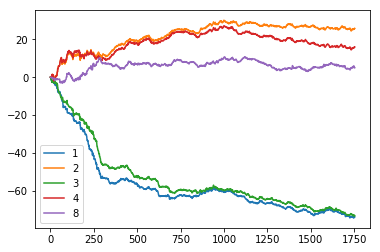

In [32]:
plt.plot(aero_unweighted_bin1, label ="1")
plt.plot(aero_unweighted_bin2, label = "2")
plt.plot(aero_unweighted_bin3, label = "3")
plt.plot(aero_unweighted_bin4, label = "4")
plt.plot(aero_unweighted_bin5, label = "5")
plt.plot(aero_unweighted_bin8, label = "8")
plt.legend()

In [ ]:
#aerospace weighted lol this will be funny

In [33]:
aero_weighted_bin1 = binary_weighted_bet_strat(directory, stocks_aerospace,[],1,.01)
aero_weighted_bin2 = binary_weighted_bet_strat(directory, stocks_aerospace,[],2,.01)
aero_weighted_bin3 = binary_weighted_bet_strat(directory, stocks_aerospace,[],3,.01)
aero_weighted_bin4 = binary_weighted_bet_strat(directory, stocks_aerospace,[],4,.01)
aero_weighted_bin5 = binary_weighted_bet_strat(directory, stocks_aerospace,[],5,.01)
aero_weighted_bin8 = binary_weighted_bet_strat(directory, stocks_aerospace,[],8,.01)

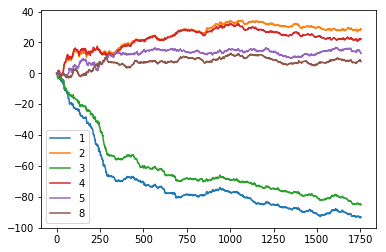

In [34]:
plt.plot(aero_weighted_bin1, label ="1")
plt.plot(aero_weighted_bin2, label = "2")
plt.plot(aero_weighted_bin3, label = "3")
plt.plot(aero_weighted_bin4, label = "4")
plt.plot(aero_weighted_bin5, label = "5")
plt.plot(aero_weighted_bin8, label = "8")
plt.legend()

In [36]:
aero_cutoff_bin1 = binary_cutoff_bet_strat(directory, stocks_aerospace,[],1,.01,.3)
aero_cutoff_bin2 = binary_cutoff_bet_strat(directory, stocks_aerospace,[],2,.01,.3)
aero_cutoff_bin3 = binary_cutoff_bet_strat(directory, stocks_aerospace,[],3,.01,.3)
aero_cutoff_bin4 = binary_cutoff_bet_strat(directory, stocks_aerospace,[],4,.01,.3)
aero_cutoff_bin5 = binary_cutoff_bet_strat(directory, stocks_aerospace,[],5,.01,.3)
aero_cutoff_bin8 = binary_cutoff_bet_strat(directory, stocks_aerospace,[],8,.01,.3)

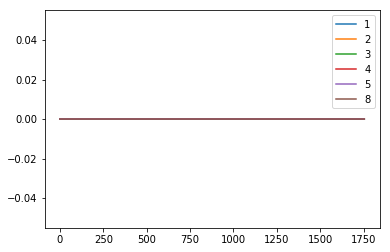

In [38]:
plt.plot(aero_cutoff_bin1, label ="1")
plt.plot(aero_cutoff_bin2, label = "2")
plt.plot(aero_cutoff_bin3, label = "3")
plt.plot(aero_cutoff_bin4, label = "4")
plt.plot(aero_cutoff_bin5, label = "5")
plt.plot(aero_cutoff_bin8, label = "8")
plt.legend()

In [ ]:
#now lets look at our random stock trades

In [42]:
directory = "random_1"
random1_unweighted_bin1 = binary_unweighted_bet_strat(directory, stocks_random1,[],1,.01)
random1_unweighted_bin2 = binary_unweighted_bet_strat(directory, stocks_random1,[],2,.01)
random1_unweighted_bin3 = binary_unweighted_bet_strat(directory, stocks_random1,[],3,.01)
random1_unweighted_bin4 = binary_unweighted_bet_strat(directory, stocks_random1,[],4,.01)
random1_unweighted_bin5 = binary_unweighted_bet_strat(directory, stocks_random1,[],5,.01)
random1_unweighted_bin8 = binary_unweighted_bet_strat(directory, stocks_random1,[],8,.01)

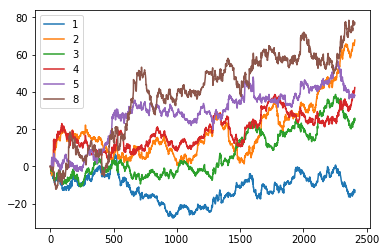

In [43]:
plt.plot(random1_unweighted_bin1, label ="1")
plt.plot(random1_unweighted_bin2, label = "2")
plt.plot(random1_unweighted_bin3, label = "3")
plt.plot(random1_unweighted_bin4, label = "4")
plt.plot(random1_unweighted_bin5, label = "5")
plt.plot(random1_unweighted_bin8, label = "8")
plt.legend()

In [44]:
random1_weighted_bin1 = binary_weighted_bet_strat(directory, stocks_random1,[],1,.01)
random1_weighted_bin2 = binary_weighted_bet_strat(directory, stocks_random1,[],2,.01)
random1_weighted_bin3 = binary_weighted_bet_strat(directory, stocks_random1,[],3,.01)
random1_weighted_bin4 = binary_weighted_bet_strat(directory, stocks_random1,[],4,.01)
random1_weighted_bin5 = binary_weighted_bet_strat(directory, stocks_random1,[],5,.01)
random1_weighted_bin8 = binary_weighted_bet_strat(directory, stocks_random1,[],8,.01)

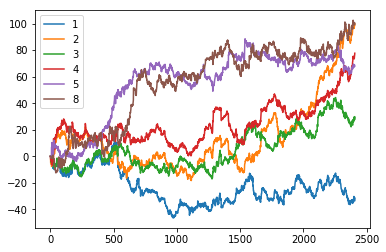

In [45]:
plt.plot(random1_weighted_bin1, label ="1")
plt.plot(random1_weighted_bin2, label = "2")
plt.plot(random1_weighted_bin3, label = "3")
plt.plot(random1_weighted_bin4, label = "4")
plt.plot(random1_weighted_bin5, label = "5")
plt.plot(random1_weighted_bin8, label = "8")
plt.legend()

In [46]:
random1_cutoff_bin1 = binary_cutoff_bet_strat(directory, stocks_random1,[],1,.01,.3)
random1_cutoff_bin2 = binary_cutoff_bet_strat(directory, stocks_random1,[],2,.01,.3)
random1_cutoff_bin3 = binary_cutoff_bet_strat(directory, stocks_random1,[],3,.01,.3)
random1_cutoff_bin4 = binary_cutoff_bet_strat(directory, stocks_random1,[],4,.01,.3)
random1_cutoff_bin5 = binary_cutoff_bet_strat(directory, stocks_random1,[],5,.01,.3)
random1_cutoff_bin8 = binary_cutoff_bet_strat(directory, stocks_random1,[],8,.01,.3)

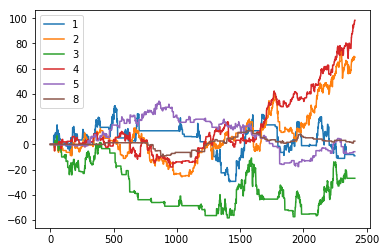

In [48]:
plt.plot(random1_cutoff_bin1, label ="1")
plt.plot(random1_cutoff_bin2, label = "2")
plt.plot(random1_cutoff_bin3, label = "3")
plt.plot(random1_cutoff_bin4, label = "4")
plt.plot(random1_cutoff_bin5, label = "5")
plt.plot(random1_cutoff_bin8, label = "8")
plt.legend()

In [52]:
directory = "random_2"
random2_unweighted_bin1 = binary_unweighted_bet_strat(directory, stocks_random2,[],1,.01)
random2_unweighted_bin2 = binary_unweighted_bet_strat(directory, stocks_random2,[],2,.01)
random2_unweighted_bin3 = binary_unweighted_bet_strat(directory, stocks_random2,[],3,.01)
random2_unweighted_bin4 = binary_unweighted_bet_strat(directory, stocks_random2,[],4,.01)
random2_unweighted_bin5 = binary_unweighted_bet_strat(directory, stocks_random2,[],5,.01)
random2_unweighted_bin8 = binary_unweighted_bet_strat(directory, stocks_random2,[],8,.01)

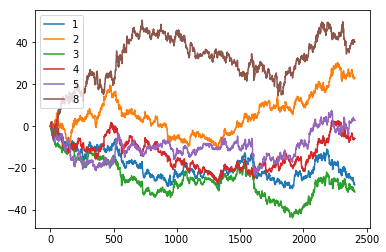

In [53]:
plt.plot(random2_unweighted_bin1, label ="1")
plt.plot(random2_unweighted_bin2, label = "2")
plt.plot(random2_unweighted_bin3, label = "3")
plt.plot(random2_unweighted_bin4, label = "4")
plt.plot(random2_unweighted_bin5, label = "5")
plt.plot(random2_unweighted_bin8, label = "8")
plt.legend()

In [54]:
random2_weighted_bin1 = binary_weighted_bet_strat(directory, stocks_random2,[],1,.01)
random2_weighted_bin2 = binary_weighted_bet_strat(directory, stocks_random2,[],2,.01)
random2_weighted_bin3 = binary_weighted_bet_strat(directory, stocks_random2,[],3,.01)
random2_weighted_bin4 = binary_weighted_bet_strat(directory, stocks_random2,[],4,.01)
random2_weighted_bin5 = binary_weighted_bet_strat(directory, stocks_random2,[],5,.01)
random2_weighted_bin8 = binary_weighted_bet_strat(directory, stocks_random2,[],8,.01)

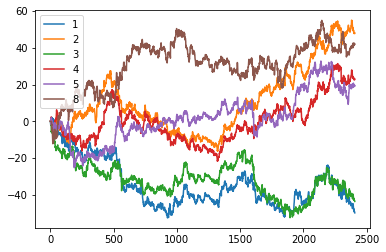

In [55]:
plt.plot(random2_weighted_bin1, label ="1")
plt.plot(random2_weighted_bin2, label = "2")
plt.plot(random2_weighted_bin3, label = "3")
plt.plot(random2_weighted_bin4, label = "4")
plt.plot(random2_weighted_bin5, label = "5")
plt.plot(random2_weighted_bin8, label = "8")
plt.legend()

In [56]:
random2_cutoff_bin1 = binary_cutoff_bet_strat(directory, stocks_random2,[],1,.01,.3)
random2_cutoff_bin2 = binary_cutoff_bet_strat(directory, stocks_random2,[],2,.01,.3)
random2_cutoff_bin3 = binary_cutoff_bet_strat(directory, stocks_random2,[],3,.01,.3)
random2_cutoff_bin4 = binary_cutoff_bet_strat(directory, stocks_random2,[],4,.01,.3)
random2_cutoff_bin5 = binary_cutoff_bet_strat(directory, stocks_random2,[],5,.01,.3)
random2_cutoff_bin8 = binary_cutoff_bet_strat(directory, stocks_random2,[],8,.01,.3)

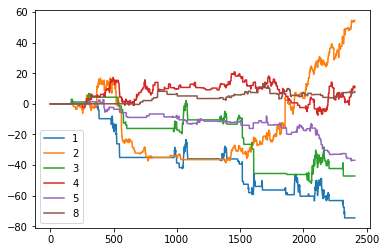

In [57]:
plt.plot(random2_cutoff_bin1, label ="1")
plt.plot(random2_cutoff_bin2, label = "2")
plt.plot(random2_cutoff_bin3, label = "3")
plt.plot(random2_cutoff_bin4, label = "4")
plt.plot(random2_cutoff_bin5, label = "5")
plt.plot(random2_cutoff_bin8, label = "8")
plt.legend()

In [58]:
directory = "random_3"
random3_unweighted_bin1 = binary_unweighted_bet_strat(directory, stocks_random3,[],1,.01)
random3_unweighted_bin2 = binary_unweighted_bet_strat(directory, stocks_random3,[],2,.01)
random3_unweighted_bin3 = binary_unweighted_bet_strat(directory, stocks_random3,[],3,.01)
random3_unweighted_bin4 = binary_unweighted_bet_strat(directory, stocks_random3,[],4,.01)
random3_unweighted_bin5 = binary_unweighted_bet_strat(directory, stocks_random3,[],5,.01)
random3_unweighted_bin8 = binary_unweighted_bet_strat(directory, stocks_random3,[],8,.01)

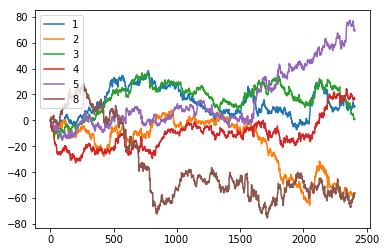

In [59]:
plt.plot(random3_unweighted_bin1, label ="1")
plt.plot(random3_unweighted_bin2, label = "2")
plt.plot(random3_unweighted_bin3, label = "3")
plt.plot(random3_unweighted_bin4, label = "4")
plt.plot(random3_unweighted_bin5, label = "5")
plt.plot(random3_unweighted_bin8, label = "8")
plt.legend()

In [60]:
random3_weighted_bin1 = binary_weighted_bet_strat(directory, stocks_random3,[],1,.01)
random3_weighted_bin2 = binary_weighted_bet_strat(directory, stocks_random3,[],2,.01)
random3_weighted_bin3 = binary_weighted_bet_strat(directory, stocks_random3,[],3,.01)
random3_weighted_bin4 = binary_weighted_bet_strat(directory, stocks_random3,[],4,.01)
random3_weighted_bin5 = binary_weighted_bet_strat(directory, stocks_random3,[],5,.01)
random3_weighted_bin8 = binary_weighted_bet_strat(directory, stocks_random3,[],8,.01)

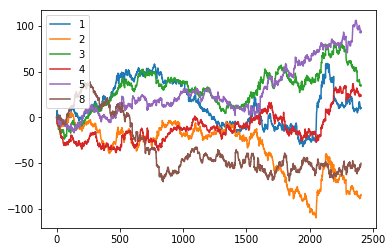

In [61]:
plt.plot(random3_weighted_bin1, label ="1")
plt.plot(random3_weighted_bin2, label = "2")
plt.plot(random3_weighted_bin3, label = "3")
plt.plot(random3_weighted_bin4, label = "4")
plt.plot(random3_weighted_bin5, label = "5")
plt.plot(random3_weighted_bin8, label = "8")
plt.legend()

In [62]:
random3_cutoff_bin1 = binary_cutoff_bet_strat(directory, stocks_random3,[],1,.01,.3)
random3_cutoff_bin2 = binary_cutoff_bet_strat(directory, stocks_random3,[],2,.01,.3)
random3_cutoff_bin3 = binary_cutoff_bet_strat(directory, stocks_random3,[],3,.01,.3)
random3_cutoff_bin4 = binary_cutoff_bet_strat(directory, stocks_random3,[],4,.01,.3)
random3_cutoff_bin5 = binary_cutoff_bet_strat(directory, stocks_random3,[],5,.01,.3)
random3_cutoff_bin8 = binary_cutoff_bet_strat(directory, stocks_random3,[],8,.01,.3)

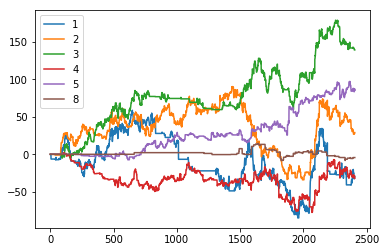

In [63]:
plt.plot(random3_cutoff_bin1, label ="1")
plt.plot(random3_cutoff_bin2, label = "2")
plt.plot(random3_cutoff_bin3, label = "3")
plt.plot(random3_cutoff_bin4, label = "4")
plt.plot(random3_cutoff_bin5, label = "5")
plt.plot(random3_cutoff_bin8, label = "8")
plt.legend()

In [ ]:
directory = "Top25Stocks"
top25_unweighted_bin1 = binary_unweighted_bet_strat(directory, stocks_Top25,[],1,.01)
top25_unweighted_bin2 = binary_unweighted_bet_strat(directory, stocks_Top25,[],2,.01)
top25_unweighted_bin3 = binary_unweighted_bet_strat(directory, stocks_Top25,[],3,.01)
top25_unweighted_bin4 = binary_unweighted_bet_strat(directory, stocks_Top25,[],4,.01)
top25_unweighted_bin5 = binary_unweighted_bet_strat(directory, stocks_Top25,[],5,.01)
top25_unweighted_bin8 = binary_unweighted_bet_strat(directory, stocks_Top25,[],8,.01)

In [ ]:
plt.plot(top25_unweighted_bin1, label ="1")
plt.plot(top25_unweighted_bin2, label = "2")
plt.plot(top25_unweighted_bin3, label = "3")
plt.plot(top25_unweighted_bin4, label = "4")
plt.plot(top25_unweighted_bin5, label = "5")
plt.plot(top25_unweighted_bin8, label = "8")
plt.legend()

In [102]:
returns2 = binary_unweighted_bet_strat(master,[],2,.01)

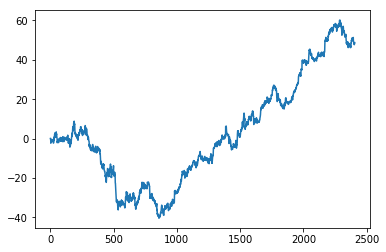

In [103]:
plt.plot(returns2)

In [91]:
returns2 = binary_unweighted_bet_strat(master,[],2,.01)
returns3 = binary_unweighted_bet_strat(master,[],3,.01)
returns4 = binary_unweighted_bet_strat(master,[],4,.01)
returns8 = binary_unweighted_bet_strat(master,[],8,.01)

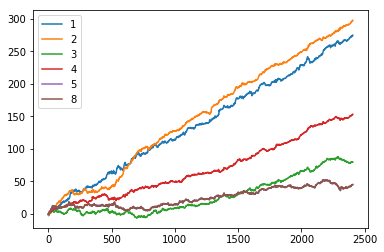

In [92]:
plt.plot(returns1, label ="1")
plt.plot(returns2, label = "2")
plt.plot(returns3, label = "3")
plt.plot(returns4, label = "4")
plt.plot(returns, label = "5")
plt.plot(returns, label = "8")
plt.legend()
#pylab.legend(loc='upper left')

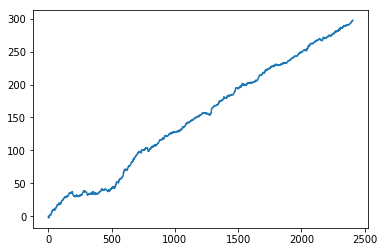

In [84]:
plt.plot(returns2)

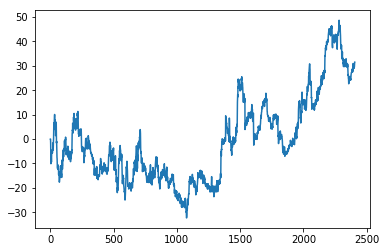

In [105]:
plt.plot(weighted_returns1)

In [106]:
weighted_returns2 = binary_weighted_bet_strat(master,[],2,.01)

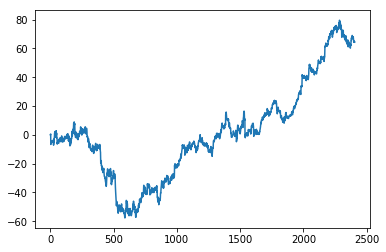

In [107]:
plt.plot(weighted_returns2)

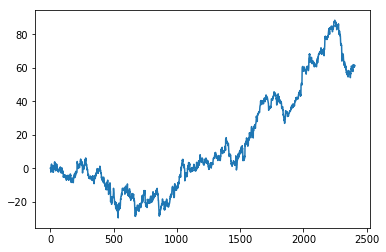

In [108]:
weighted_returns4 = binary_weighted_bet_strat(master,[],4,.01)
plt.plot(weighted_returns4)

In [117]:
##Now for the main script
#lets see our profits if we bet same amount every single time on the favorite
def binary_cutoff_bet_strat(master,stocks, bins, flexibility,cutoff):
    players = createPlayers("./SmallStocks",stocks, bins)
    trading_stocks = players.keys()
    #daily profits are the cumulative profits we have each day from all of our trades
    #day profits are profits that we have within each day weighted by how much money we put on
    #since this strat is unweighted for now we will set all the weights to be 1
    daily_profits = [0]
    
    for i in range(master.shape[0]-1):
        players_n = copy.deepcopy(players)
        totalCollisions = 0
        day_profits = []
        
        for stock_1 in trading_stocks:
            numCollisions = 0
            newElo = 0
            bin_1 = get2DBin((master.iloc[i][stock_1+"_daily_returns"],master.iloc[i][stock_1+"_5_day_returns"]), bins)
            a = bin_1[0]
            b = bin_1[1]
            
            for stock_2 in trading_stocks:
                bin_2 = get2DBin((master.iloc[i][stock_2+"_daily_returns"],master.iloc[i][stock_2+"_5_day_returns"]), bins)
                
                
                #the meat of the program happens in here
                if stock_1 != stock_2 and bin_1 == bin_2:
                    expected_result = players[stock_1][a][b]-players[stock_2][a][b]
                    result = master.iloc[i+1][stock_1+"_daily_returns"]-master.iloc[i+1][stock_2+"_daily_returns"]
                    numCollisions +=1
                    
                    #bet on company 1
                    if expected_result > 0:
                        day_profits.append((result,int(expected_result>cutoff)))
                    #bet on company 2
                    else:
                        day_profits.append((-result,int(expected_result<-cutoff)))

                    newElo += updateElo(players[stock_1][a][b],
                                        players[stock_2][a][b], result,.01)
                    #print(stock_1)
                    #print(stock_2)
                    #print()
            if numCollisions != 0:
                players_n[stock_1][a][b] = newElo/numCollisions

        players = players_n
        #calculate overall profit
        weighted = 0
        total = 0.00001
        for pair in day_profits:
            weighted += pair[0]*pair[1]
            total += pair[1]
        daily_profits.append(daily_profits[-1]+weighted/total)
        #print(players)
        #print(daily_profits)
        #print()
        #return
        #print (i)
    return(daily_profits)
cutoff_returns1 = binary_cutoff_bet_strat(master, [],1,.01,.8)      

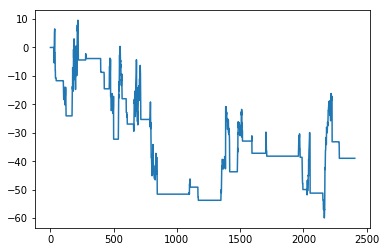

In [116]:
plt.plot(cutoff_returns1)

In [113]:
cutoff_returns2 = binary_cutoff_bet_strat(master, [],2,.01)

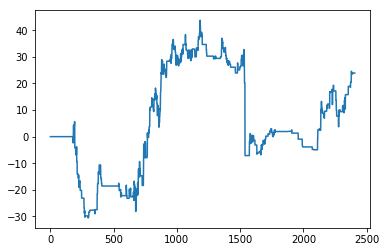

In [114]:
plt.plot(cutoff_returns2)

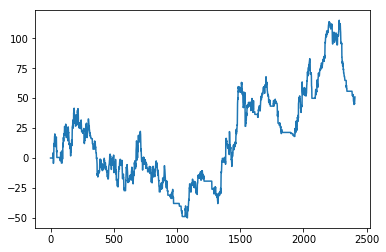

In [118]:
cutoff_returns2_sell3 = binary_cutoff_bet_strat(master, [],1,.01,.3)
plt.plot(cutoff_returns2_sell3)

In [33]:
players = binary_unweighted_bet_strat("random_walks", consolidated_table("random_walks"), [], 8, .01)

In [36]:
vals = []
for i in stocks:
    arr = np.array(players[i])
    vals.append(np.linalg.norm(arr))
np.mean(vals)

0.21352105251896472

In [37]:
players2 = binary_unweighted_bet_strat("random_1", consolidated_table("random_1"), [], 8, .01)

0.40718718250703284

In [31]:
vals = []
for key in players2:
    arr = np.array(players2[key])
    vals.append(np.linalg.norm(arr))
np.mean(vals)

0.23676941234479232

In [40]:
import os
spy = os.listdir("SP500Stocks")

In [57]:
master = consolidated_table("SP500Stocks")

In [68]:
elos = []
for i in range(15):
    stocks = []
    for stock in np.random.choice(spy, size=5, replace=False):
        stocks.append(stock[:-4])
    players = binary_unweighted_bet_strat("SP500Stocks", master, stocks, 8, 0.1)
    vals = []
    for key in players:
        arr = np.array(players[key])
        vals.append(np.linalg.norm(arr))
    elos.append(np.mean(vals))
    print("appended")
    print(elos[-1])

appended
0.33937674996678285
appended
0.26901312328719995
appended
0.260195729710092
appended
0.3169371770693825
appended
0.331314461278948
appended
0.3012582369751993
appended
0.29453460211117755
appended
0.2652084092683923
appended
0.23831315993223945
appended
0.331302189353504
appended
0.2698276520529361
appended
0.20790517525118285
appended
0.3330918227987429
appended
0.25238028699250126
appended
0.27757562976274197


(array([1., 0., 1., 2., 3., 1., 1., 1., 1., 4.]),
 array([0.20790518, 0.22105233, 0.23419949, 0.24734665, 0.26049381,
        0.27364096, 0.28678812, 0.29993528, 0.31308244, 0.32622959,
        0.33937675]),
 <a list of 10 Patch objects>)

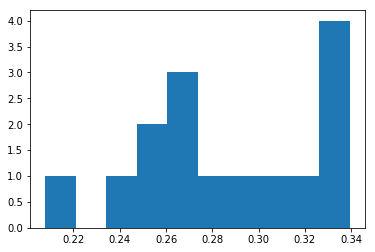

In [69]:
import matplotlib.pyplot as plt
plt.hist(elos)

In [70]:
np.mean(elos)

0.2858822937207348

In [71]:
np.std(elos)

0.037997632574283235